## Neural Network

In [46]:
import torch
import torchmetrics
from torch import nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import  classification_report, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from scipy.stats import norm

# Loading pre processed datas
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
val_features = np.load('Pre_Processed_Data/val_features.npy')
val_labels = np.load('Pre_Processed_Data/val_labels.npy')
test_features = np.load('Pre_Processed_Data/test_features.npy')
test_labels = np.load('Pre_Processed_Data/test_labels.npy')
weights = np.load('Pre_Processed_Data\class_weights.npy', allow_pickle=True).item()

# Value to distinguish if an istance belongs to class 0 or class 1 
round_treshold = 0.50

# Let's convert data to PyTorch tensors

In [47]:
# Convert the class weight dictionary to a PyTorch tensor of type Float
weights_tensor = torch.tensor([weights[i] for i in range(len(weights))]).float()

X_train = torch.tensor(train_features).float()
y_train = torch.tensor(train_labels).long()
X_val = torch.tensor(val_features).float()
y_val = torch.tensor(val_labels).long()
X_test = torch.tensor(test_features).float()
y_test = torch.tensor(test_labels).long()

# Creating DataLoaders for the training and validation set

In [48]:
batch_size = 40
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Defining neural network architecture

In [49]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        x = torch.sigmoid(x)
        return x


# Creating an instance of the model

In [50]:
model = Net()

# Let's define the loss function and the optimizer

In [51]:
# I define the loss function and optimizer with class weights
# I create an instance of the CrossEntropyLoss policy using class weights
criterion_class0 = nn.BCELoss(weight=weights_tensor[0])
criterion_class1 = nn.BCELoss(weight=weights_tensor[1])
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)

# Defining the function to validate the model on the validation set

In [52]:
def validate_model(model, validation_loader):
    model.eval()
    criterion_class0_valuation = nn.BCELoss(weight=weights_tensor[0])
    criterion_class1_valuation = nn.BCELoss(weight=weights_tensor[1])
    total_loss = 0
    with torch.no_grad():
        for features, labels in validation_loader:
            outputs = model(features)
            new_labels = labels.unsqueeze(1)
            new_labels = new_labels.float()
            for j in range (len(new_labels)-1):
                if new_labels[j] == 0:
                    loss = criterion_class0_valuation(outputs[j][0],new_labels[j][0])
                else:
                    loss = criterion_class1_valuation(outputs[j][0],new_labels[j][0])
            total_loss+=loss.item() 
    mean_loss = total_loss / len(validation_loader)
    return mean_loss

# I define the variables for early stopping

In [53]:
# early stopping variables definitions
best_bce_loss_validation = np.inf  # Initial value for comparison
best_bce_loss = np.inf
patience = 185  # Number of epochs to tolerate the decrease in accuracy on the validation set
delta_threshold = 0.001 # Improvement threshold based on accuracy on the validation set
counter = 0  # Counter for the number of epochs without improvement.

# Training the model

Stopping early at epoch 1233


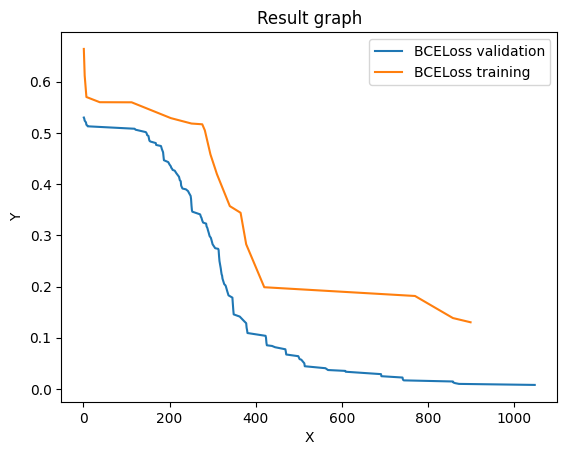

In [54]:
num_epochs=10000
x = []
x2 = []
y = []
y2 = []
for epoch in range(num_epochs):
    
    model.train() 
    epoch_loss_sum = 0.0 
    for (features,labels) in (train_loader):

        optimizer.zero_grad() 
        outputs=model(features)
        new_labels = labels.unsqueeze(1)
        new_labels = new_labels.float()
   
        for j in range (len(new_labels)-1):
            if new_labels[j] == 0:
                loss = criterion_class0(outputs[j][0],new_labels[j][0])
            else:
                loss = criterion_class1(outputs[j][0],new_labels[j][0])
      
        
        epoch_loss_sum+=loss.item() 
        loss.backward() 
        optimizer.step()
        loss = 0

    epoch_loss_avg=epoch_loss_sum/len(train_loader) 
    #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss_avg:.4f}')
    
    # Verifico se l'accuratezza corrente sul set di validazione è migliore dell'accuratezza migliore finora
    bce_loss_validation = validate_model(model,val_loader)
    if best_bce_loss_validation - bce_loss_validation > delta_threshold:
        x.append(epoch + 1)
        y.append(bce_loss_validation)
        best_bce_loss_validation = bce_loss_validation
        counter=0 
        torch.save(model.state_dict(),'best_model.pth') 
    else: 
        counter+=1 
    
    if epoch_loss_avg < best_bce_loss:
        x2.append(epoch+1)
        y2.append(epoch_loss_avg)
        best_bce_loss = epoch_loss_avg
    
    if counter>=patience:
        print(f'Stopping early at epoch {epoch + 1}')
        break
# Creating the graph
plt.plot(x, y, label = 'BCELoss validation')
plt.plot(x2, y2, label = 'BCELoss training')
# Adding labels
plt.xlabel('X')
plt.ylabel('Y')

# Graph title
plt.title('Result graph')
plt.legend()

# Graph visualization
plt.show()

# Carica il miglior modello

In [55]:
# Loading the best model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

# Evaluating the model on test set

In [56]:
from sklearn.metrics import precision_score
precision = torchmetrics.Precision(num_classes=2, task='binary')
correct = 0
total = 0
precision_values = []
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        preds = (outputs > round_treshold).float()
        new_labels = labels.unsqueeze(1)
        new_labels = new_labels.float()
   
        for j in range (len(new_labels)-1):
            precision.update(preds,new_labels)
precision = precision.compute()
print(f'Precision on test set: {precision:.4f}')

Precision on test set: 0.6252


# Confusion Matrix

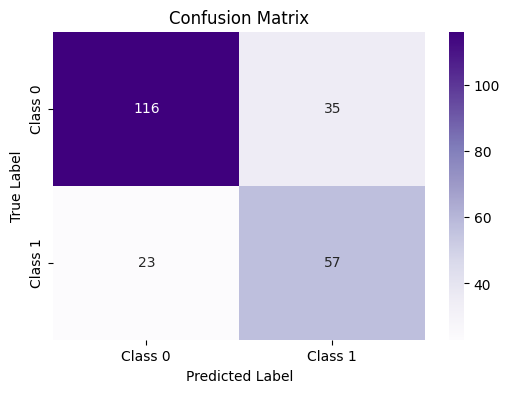

In [57]:
# Compute confusion matrix
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        preds = (outputs > round_treshold).float()
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
cm = confusion_matrix(y_true, y_pred)
# Define class labels
class_labels = ['Class 0', 'Class 1']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report

In [58]:
model.eval()
test_predictions = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        preds = (outputs > round_treshold).float()
        test_predictions.extend(preds.tolist())

# Calcolo il report di classificazione
report = classification_report(test_labels.tolist(), test_predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80       151
           1       0.62      0.71      0.66        80

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.73       231
weighted avg       0.76      0.75      0.75       231



# ROC and AUC

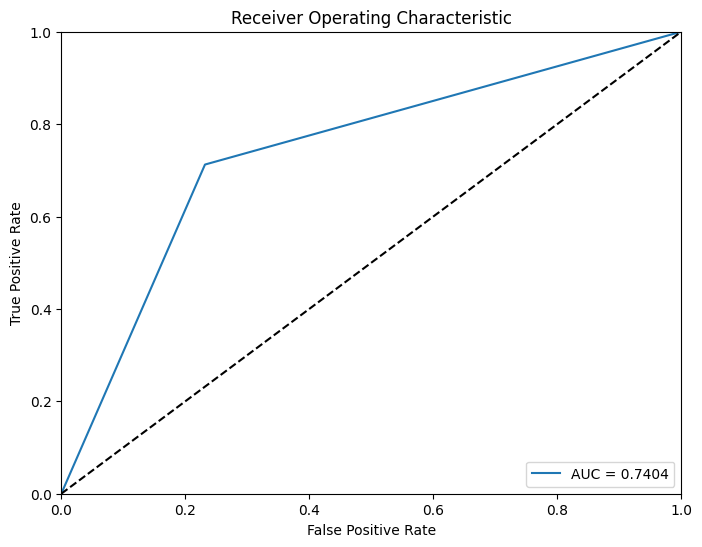

AUC: 0.7403559602649007


In [59]:
model.eval()
test_probabilities = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        preds = (outputs > round_treshold).float()
        test_probabilities.extend(preds.tolist())

# Calcolo la curva ROC e l'AUC
fpr, tpr, thresholds = roc_curve(test_labels.tolist(), test_probabilities)
auc = roc_auc_score(test_labels.tolist(), test_probabilities)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("AUC:", auc)

# Confidence interval

In [60]:

def calculate_accuracy(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for features, labels in data_loader:
            outputs = model(features)
            predicted_probs = outputs.squeeze()
            predicted_labels = (predicted_probs > round_treshold).long()
            predictions.extend(predicted_labels.tolist())
            true_labels.extend(labels.tolist())
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# Calcola l'accuratezza sul set di test
test_accuracy = calculate_accuracy(model, test_loader)

# Calcola il numero di campioni nel set di test
num_samples = len(test_labels)

# Calcola l'intervallo di confidenza utilizzando l'accuratezza sul set di test e il numero di campioni
confidence_level = 0.95  # Livello di confidenza desiderato
standard_error = np.sqrt((test_accuracy * (1 - test_accuracy)) / num_samples)
z = norm.ppf(1 - (1 - confidence_level) / 2)
margin_of_error = z * standard_error
lower_bound = test_accuracy - margin_of_error
upper_bound = test_accuracy + margin_of_error

# Stampa l'intervallo di confidenza
print(f"Confidence Interval ({confidence_level * 100}%): [{lower_bound:.4f}, {upper_bound:.4f}]")

Intervallo di confidenza (95.0%): [0.6930, 0.8048]
